# The Mental Game of Python


This notebook is about a [talk](https://www.youtube.com/watch?v=UANN2Eu6ZnM) presented by Raymond Hettinger at PyBay2019 - 4th annual Bay Area Regional Python conference.

I took this note for better understanding.

## Agenda

The talk includes 10 strategies and some examples.

1. Chunking and Aliasing (eg. Random module)
2. - Solve a related but simpler problem
   - Incremental development (eg. Tree Walker)
3. Build classes independently and let inheritance discover itself (eg. Validators)
4. Repeat tasks manually until patterns emerge, then move to a function. Continue to generalize as needed. (Convert CSV to XML)
5. Consider object orient programming as a graph traversal problem (eg. Kaprekar Function)
6. - Separate ETL from analysis. Separate analysis from presentation.
   - Verify type, verify size, view subset of data, and test a subset.
   - Humans should never gaze upon unsorted data.
   - Sets and dict groupings are primary tools for data analysis.
   - (eg. Analysis of the Kaprekar function)

## 1. Chunking and Aliasing

The number of objects an average human can hold in short-term memory is 7 ± 2 according to [Miller's Law](https://en.wikipedia.org/wiki/The_Magical_Number_Seven,_Plus_or_Minus_Two). That means we don't have enough 'register' to deal with large data. 

The solution is chunking, group individual pieces of information into a single chunk. Even with chunking, for example shrink 5-register problem to 1-register, we can still do better(1 to 0) by Aliasing, which means take an existing thing you know and link the knowledge to the problem.

### random module example

```python
from random import *
random() # 0.0 <= x < 1.0

# original
50 + random() * 200 # 50.0 <= x < 250.0
# chunking
uniform(50, 250)
```
random function gives a value of x in between 0.0 and 1.0. If we want to extend the range, we may do ```50 + random() * 200```. But ```50 + random() * 200``` already use up 3 registers in our cognitive load, we can chunk the problem to make it better by ```uniform()```.(If the function doesn't exist, create it.) 

```python
# original
5000 + int(random() * 200) * 5 # 5000 <= x < 6000 in multiples of 5
# chunking
randrange(5000, 6000, 5)
```

Random module already chunk for us. If the function doesn't exist, we need to chunk for ourselves all the time.

```python
outcomes = ['win', 'lose', 'draw', 'double', 'try again']
# original
outcomes[int(random() * len(outcomes))]
# chunking with fewer decryption steps
outcomes[randrange(len(outcomes))]
# chunk more
choice(outcomes)

# original
[choice(outcomes) for i in range(10)]
# chunking
choices(outcomes, k=10)
```

## 2. Solve a related but simpler problem and Incremental development

### Tree Walker example

Given a target find the path to it, starting with any node in a tree.
```python
tree['two'][3]['seven'] -> 7

```

In [1]:
tree = {
    'one': [
        'abc',
        'def',
        'ghi',
        {
            'four': 4,
            'five': 5,
        },
    ],
    'two': [
        'jkl',
        'mno',
        'BLUE',
        {
            'six': 6,
            'seven': 7,
        },
    ],
    'three': [
        'qrs',
        'BLUE',
        {
            'five': 5,
            'eight': 8,
            'nine': 9,
        }
    ],
}

strategy = '''
Strategy: Solve related but simpler problem
Strategy: Incremental development
'''

To solve the problem above, first try to solve related but simpler problem:
- Just count the number of occurences by recursion

In [2]:
def countem(node, target):
    'Count occurences of the target in tree'
    if node == target:
        return 1
    if isinstance(node, list):
        return sum(countem(subnode, target) for subnode in node)
    if isinstance(node, dict):
        return sum(countem(subnode, target) for subnode in node.values())
    return 0

countem(tree, 5)

2

Then, incremental development. Loop over the node, enumerate it, return the path when find the target.

BTW, the code from the speech (```find_one_path()```shown below) just find the first path of the target. 

In [3]:
def find_one_path(node, target):
    if node == target:
        return f' -> {target!r}'
    
    if isinstance(node, list):
        for i, subnode in enumerate(node):
            path = find_one_path(subnode, target)
            if path:
                return f'[{i}]{path}'
    
    if isinstance(node, dict):
        for k, v in node.items():
            path = find_one_path(v, target)
            if path:
                return f'[{k!r}]{path}'
    return ''

print(find_one_path(tree, 5))

['one'][3]['five'] -> 5


I extended the application to find all path lead to the target.

The key point here is recursing the path and then exit the recursion by print(). Without using ```return```, we can loop over all paths in tree.

In [4]:
def find_all_path(node, target, path='root'):
    
    if isinstance(node, list):
        for i, subnode in enumerate(node):
            find_all_path(subnode, target, path + f'[{i!r}]')
         
    elif isinstance(node, dict):
        for k, v in node.items():
            find_all_path(v, target, path + f'[{k!r}]')
    else:
        if node == target:
            print(path + ' -> ' + f'{node!r}')
            
find_all_path(tree, 5)

root['one'][3]['five'] -> 5
root['three'][2]['five'] -> 5


## 3. Build classes independently and let inheritance discover itself

Why don't professional chess players think more than 10 moves in advance?

Because there're too many combinatorics explosion. We prefer more agile methods of letting the inheritance to discover itself.

### Validator Example

Problem: build a collection of data validation utilities using descriptors.

Check out the example blow, the two classes has some commonalities.

Example: 
```python
'''
class Resource:
    resource_id = Number(minvalue=0)
    name = String(minsize=2, maxsize=20)
    category = Oneof('pending', 'idle', 'acitive', 'shutdown')
'''

class Number:
    
    def __init__(self, minvalue=None, maxvalue=None):
        self.minvalue = minvalue
        self.maxvalue = maxvalue
        
    def __set_name__(self, owner, name):
        return self.private_name = f'_{name}'
    
    def __get__(self, obj, objtype=None):
        return getattr(obj, self.private_name)
    
    def __set__(self, obj, value):
        # Always raise TypeError before ValueError!
        if not isinstance(value, int, float):
            raise TypeError(f'Expected {value!r} to be an int or float')
        if self.minvalue is not None and value < self.minvalue:
            raise ValueError(f'Expected {value!r} to be at least {self.minvalue!r}')
        if self.maxvalue is not None and value > self.maxvalue:
            raise ValueError(f'Expected {value!r} to be no more than {self.maxvalue!r}')
        setattr(obj, self.private_name, value)
        
class String:
    
    def __init__(self, minsize=None, maxsize=None, predicate=None):
        self.minsize = minsize
        self.maxsize = maxsize
        self.predicate = predicate
        
    def __set_name__(self, owner, name):
        return self.private_name = f'_{name}'
    
    def __get__(self, obj, objtype=None):
        return getattr(obj, self.private_name)
    
    def __set__(self, obj, value):
        if not isinstance(value, str):
            raise TypeError(f'Expected {value!r} to be a str')
        if self.minsize is not None and len(value) < self.minsize:
            raise ValueError(f'Expected {value!r} to be no smaller than {self.minvalue!r}')
        if self.maxsize is not None and len(value) > self.maxsize:
            raise ValueError(f'Expected {value!r} to be no bigger than {self.maxvalue!r}')
        if self.predicate is not None and not self.predicate(value):
            raise ValueError(f'Expected {self.predicate!r} to be true for {value!r}')
        setattr(obj, self.private_name, value)
```

```python

```

The take-away here is do less planning, make class after class, then discover the commonalities and move them into another class.

Make the parent class ```Validator``` after the child class, this is a reliable technique for finding out what is truly in common as opposed to trying to plan it in advance which makes this a harder problem.

```python

class Validator:
    
    def __set_name__(self, owner, name):
        return self.private_name = f'_{name}'
    
    def __get__(self, obj, objtype=None):
        return getattr(obj, self.private_name)
    
    def __set__(self, obj, value):
        self.validate(value)
        setattr(obj, self.private_name, value)
    
    
class Number(Validator):
    
    def __init__(self, minvalue=None, maxvalue=None):
        self.minvalue = minvalue
        self.maxvalue = maxvalue
        
    def validate(self, value):
        if not isinstance(value, int, float):
            raise TypeError(f'Expected {value!r} to be an int or float')
        if self.minvalue is not None and value < self.minvalue:
            raise ValueError(f'Expected {value!r} to be at least {self.minvalue!r}')
        if self.maxvalue is not None and value > self.maxvalue:
            raise ValueError(f'Expected {value!r} to be no more than {self.maxvalue!r}')
        
class String(Validator):
    
    def __init__(self, minsize=None, maxsize=None, predicate=None):
        self.minsize = minsize
        self.maxsize = maxsize
        self.predicate = predicate

    def validate(self, value):
        if not isinstance(value, str):
            raise TypeError(f'Expected {value!r} to be a str')
        if self.minsize is not None and len(value) < self.minsize:
            raise ValueError(f'Expected {value!r} to be no smaller than {self.minvalue!r}')
        if self.maxsize is not None and len(value) > self.maxsize:
            raise ValueError(f'Expected {value!r} to be no bigger than {self.maxvalue!r}')
        if self.predicate is not None and not self.predicate(value):
            raise ValueError(f'Expected {self.predicate!r} to be true for {value!r}')
            
class Oneof(Validator):
    
    # Idealy whenever you're going to use the in operator you should use it on set, 
    # which is fast at membership testing.
    def __init__(self, *choices):
        self.allowed_options = set(choices)
        
    def validate(self, value):
        if value not self.allowed_options:
            raise ValueError(f'Expected {value!r} in {self.allowed_options!r}')
```

## 4. Repeat tasks manually until patterns emerge, then move to a function. Continue to generalize as needed. 

The example is converting a CSV file to XML. 

Check the code below, there are some patterns when creating ```person```, ```fn``` and ```jt```. So move them into a function. We can find out that ```person``` has a difference from ```fn``` and ```jt```, which is the parent, so create a new argument in the function to continue generalize.

```python
from xml.etree.ElementTree import Element, ElementTree, dump
import csv

root = Element('contact_list', status='Public', company='Raisins R Us, Inc')
root.text = '\n'
root.tail = '\n'

with open('raisin_team.csv') as f:
    for lname, fname, title, email, phone in csv.reader(f):
        person = Element('person')
        person.text = '\n'
        person.tail = '\n'
        root.append(person)
        
        fn = Element('full_name')
        fn.text = f'{fname}{lname}'
        fn.tail = '\n'
        person.append(fn)
        
        jt = Element('job_title')
        jt.text = title
        jt.tail = '\n'
        person.append(jt)

dump(root)
```

Here is the code after generalization.
```python
from xml.etree.ElementTree import Element, ElementTree, dump
import csv

def add_element(parent, tag, text='\n', **kwargs):
    elem = Element(tag, **kwargs)
    elem.text = text
    elem.tail = '\n'
    if parent is not None:
        parent.append(elem)
    return elem

root = add_element(tag='contact_list', status='Public', company='Raisins R Us, Inc')

with open('raisin_team.csv') as f:
    for lname, fname, title, email, phone in csv.reader(f):
        person = add_element(root, 'person')
        add_element(person, 'full_name', f'{fname}{lname}')
        add_element(person, 'job_title', title)
        add_element(person, 'work_phone', phone)
        add_element(person, 'work_email', email)
        
dump(root)
```

## 5. Consider object orient programming as a graph traversal problem (eg. Kaprekar Function)

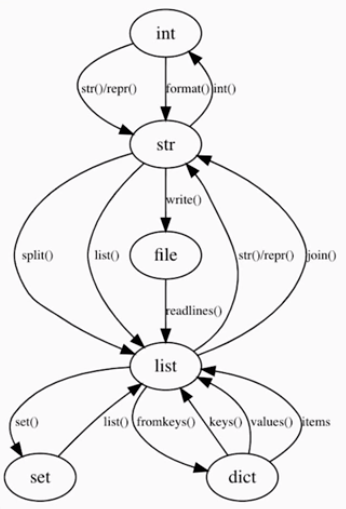

The notion about object-oriented programming is you don't write classes unless necessary.

The science of object-oriented programming in a language that has rich eco system is *taking a bunch of tools that each have capabilities you want and figure out how to traverse in between them*.

The island of integer is really good at add and subtract, the island of str is upper and lower case, etc. Each of these tools has a different specialty. The art is figure out what island you're on and which island has the capabilities you need and then it simply becomes a graph traversal problem how do you get there.

### Example Problem:
```

1. Take any four-digit number, using at least two different digits. (Leading zeros are required)
2. Arrange the digits in descending and then in ascending order to get two four-digit numbers, adding leading zeros if necessary.
3. Subtract the smaller number from the bigger number.
4. Go back to step 2 and repeat.

Example:
    3524 -> 5432 - 2345 -> 3087
    3087 -> 8730 - 0378 -> 8352
    8352 -> 8532 - 2358 -> 6174
    6174 -> 7641 - 1467 -> 6174
      ^----------------------o
```

In [5]:
def kap_1(n):
    s = '%04d' % n
    t = list(s)
    t.sort(reverse=True)
    big = int(''.join(t))
    t.sort()
    small = int(''.join(t))
    return big - small

def kap_2(n):
    s = format(n, '04d')
    big = int(''.join(sorted(s, reverse=True)))
    small = int(''.join(sorted(s)))
    return big - small

def recurse_kap(n):
    res = kap_2(n)
    print(res)
    if res != n:
        return recurse_kap(res)

recurse_kap(3524)

3087
8352
6174
6174
